# Magnetic Fields in Geant4 - Example SingleQuad 
Example to study behavior of G4QuadrupoleMagField in more detail and to understand basic coordinate transformations. Also supposed to be used for investigating differences in bfieldmap and MDISim
Specs for the simulation:

length = 1m
k1 < 0 ==> horizontally defocussing quad
beam energy 1 Gev

* [1 Quadrupole Fields](#qdrplFlds)
* [1.1 Particle Position](#PrtclPs)
* [1.1 Field based on Particle Position](#FldsPrtclPs)
* [1.3 Comparison of Field Components](#cmprsFldCmpts)

In [17]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt 
import numpy as np
import itertools  
# import sets
import collections as clt
from os.path import expanduser
import sys
import difflib as dl  
import re
import timeit
home = expanduser("~")

%cd ~/Python/FCCee-Synchrotron-Radiation/source/
from TfsTables import TfsReader
from Input import DataReader, readParams
from OpticsSelectTools import DataSelection 
from Tools import rel_s, calcAper, sbplSetUp
# TfsReader, 
from DF_Tools import OutputToDF
import Plot as pltdat   
from VisualSpecs import myColors as colors
from IPython.core.display import display, HTML
# temporarily disable the SetCopies warning:
pd.options.mode.chained_assignment = None

%reload_ext autoreload

%aimport Input, OpticsSelectTools, Plot

%autoreload 1
%matplotlib inline
# --------------------------- RC PARAMS STYLE SECTION -------------------------------------
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['axes.labelsize'] = 24
mpl.rcParams['axes.titlesize'] = 26  
mpl.rcParams['figure.figsize'] = 15., 10.    # figure size in inches

mpl.rcParams['legend.fontsize'] = 16
mpl.rcParams['agg.path.chunksize'] = 10000
# --------------------------- ----------------------- -------------------------------------

# --------------------------- PANDAS DISPLAY SETTINGS -------------------------------------
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 200)
# --------------------------- ----------------------- -------------------------------------

# plotpath = "/home/mlueckhof/PhD/Notes/SuperKEKB/plots/"

plotpath = home + "/temporary"
display(HTML("<style>.container { width:100% !important; }</style>"))

# some constants for LER
tesla = 0.001
meter = 1000

/home/mlueckhof/Python/FCCee-Synchrotron-Radiation/source


## 1 Quadrupole Fields in Geant4 <a class="anchor" id="qdrplFlds"></a>

How are the fields constructed in Geant? Therefore establish a way to visualize the field seen by a **single** particle moving on different paths through the IR. 
We start with a track on axis after the IP, affecting only magnets `QC1LP` and `QC2LP`. `QC1LP` is a horizontally defocusing magnet with negative `K1` while `QC2LP` is focusing with positive normal component. This is also reflected in the vertical field strength. 

In [26]:
# specific data dumped during G4 run - this frame stores the data
#
magFieldData = OutputToDF(home + '/temporary/magneticFields.dat').read_txt(verbose = 1 ) #, dropDupl = 'volname' )
magFieldData.head(10)

 *** Warning: no header specified, inferring from file ... 


,volname,chck_K1L,chck_SK1L,chck_SK0L,chck_K0L,normalQuad,skewQuad,skewDipole,normalDipole,y0,y1,y2,x_SAD,y_SAD,z_SAD,x_loc,y_loc,z_loc,x_SAD_loc,y_SAD_loc,z_SAD_loc,x_SAD_displ,y_SAD_displ,z_SAD_displ,Bx_loc,By_loc,Bz_loc,x_glob,y_glob,z_glob,Bx_glob,By_glob,Bz_glob,B_locSAD_x,B_locSAD_y,B_locSAD_z,B_glbSADtmp_x,B_glbSADtmp_y,B_glbSADtmp_z,B_glbSAD_x,B_glbSAD_y,B_glbSAD_z,BzOvrlp
0,QF_EN_1,-0.025,0,0,0,-0.000002,0,0,0,0.00000,0.000000e+00,0.00000,0.00000,0.000000e+00,0.00000,3.552710e-15,0.000000e+00,-25.0000,0.00000,-0.000000e+00,0.00000,0.00000,-0.000000e+00,0.00000,-0.000000e+00,-5.925290e-21,0,-17.6777,0.000000e+00,-17.6777,0.000000e+00,-5.925290e-21,0.000000e+00,0.000000e+00,0.000000,0,0.000000e+00,0.000000,-0.000000e+00,0.000000e+00,0.000000,-0.000000e+00,0
1,QF_EN_1,-0.025,0,0,0,-0.000002,0,0,0,0.00000,0.000000e+00,0.00000,0.00000,0.000000e+00,0.00000,3.552710e-15,0.000000e+00,-25.0000,0.00000,-0.000000e+00,0.00000,0.00000,-0.000000e+00,0.00000,-0.000000e+00,-5.925290e-21,0,-17.6777,0.000000e+00,-17.6777,0.000000e+00,-5.925290e-21,0.000000e+00,0.000000e+00,0.000000,0,0.000000e+00,0.000000,-0.000000e+00,0.000000e+00,0.000000,-0.000000e+00,0
2,QF_EN_1,-0.025,0,0,0,-0.000002,0,0,0,0.00000,0.000000e+00,0.00000,0.00000,0.000000e+00,0.00000,3.552710e-15,0.000000e+00,-25.0000,0.00000,-0.000000e+00,0.00000,0.00000,-0.000000e+00,0.00000,-0.000000e+00,-5.925290e-21,0,-17.6777,0.000000e+00,-17.6777,0.000000e+00,-5.925290e-21,0.000000e+00,0.000000e+00,0.000000,0,0.000000e+00,0.000000,-0.000000e+00,0.000000e+00,0.000000,-0.000000e+00,0
3,QF_EN_1,-0.025,0,0,0,-0.000002,0,0,0,141.42100,0.000000e+00,141.42100,135.43200,0.000000e+00,147.16700,-7.948960e-08,0.000000e+00,175.0000,135.43200,-1.802270e-14,-147.16700,135.43200,-1.802270e-14,-147.16700,-0.000000e+00,1.325740e-13,0,123.7440,0.000000e+00,123.7440,0.000000e+00,1.325740e-13,0.000000e+00,3.005870e-20,-0.000226,0,3.005870e-20,0.000226,2.766190e-20,3.118050e-20,0.000226,2.639100e-20,0
4,QF_EN_1,-0.025,0,0,0,-0.000002,0,0,0,212.13200,0.000000e+00,212.13200,203.14800,0.000000e+00,220.75000,-1.192340e-07,0.000000e+00,275.0000,203.14800,-2.703410e-14,-220.75000,203.14800,-2.703410e-14,-220.75000,-0.000000e+00,1.988620e-13,0,194.4540,0.000000e+00,194.4540,0.000000e+00,1.988620e-13,0.000000e+00,4.508810e-20,-0.000339,0,4.508810e-20,0.000339,4.149290e-20,4.677070e-20,0.000339,3.958650e-20,0
5,QF_EN_1,-0.025,0,0,0,-0.000002,0,0,0,527.09200,8.121380e-16,603.69500,501.59200,8.121380e-16,625.04400,-5.416660e+01,8.121380e-16,774.5870,501.59200,-7.735790e-14,-625.04400,501.59200,-7.735790e-14,-625.04400,-1.354500e-21,9.034020e-05,0,509.4140,8.121380e-16,586.0180,-9.577760e-22,9.034020e-05,9.577760e-22,1.290190e-19,-0.000837,0,1.290190e-19,0.000837,1.024500e-19,1.331580e-19,0.000837,9.700880e-20,0
6,QF_EN_1,-0.025,0,0,0,-0.000002,0,0,0,545.38900,1.483380e-15,712.49500,515.35900,1.483380e-15,734.50900,-1.181620e+02,1.483380e-15,864.4580,515.35900,-9.143470e-14,-734.50900,515.35900,-9.143470e-14,-734.50900,-2.474010e-21,1.970720e-04,0,527.7110,1.483380e-15,694.8170,-1.749390e-21,1.970720e-04,1.749390e-21,1.524970e-19,-0.000860,0,1.524970e-19,0.000860,1.052620e-19,1.567330e-19,0.000860,9.884430e-20,0
7,QF_EN_1,-0.025,0,0,0,-0.000002,0,0,0,616.84900,2.169420e-15,797.37500,583.23600,2.169420e-15,822.28000,-1.276510e+02,2.169420e-15,975.0070,583.23600,-1.028700e-13,-822.28000,583.23600,-1.028700e-13,-822.28000,-3.618210e-21,2.128990e-04,0,599.1710,2.169420e-15,779.6970,-2.558460e-21,2.128990e-04,2.558460e-21,1.715680e-19,-0.000973,0,1.715680e-19,0.000973,1.191250e-19,1.763630e-19,0.000973,1.119050e-19,0
8,QF_EN_1,-0.025,0,0,0,-0.000002,0,0,0,666.09400,1.539580e-15,744.23800,634.64300,1.539580e-15,771.23200,-5.525590e+01,1.539580e-15,972.2550,634.64300,-9.598820e-14,-771.23200,634.64300,-9.598820e-14,-771.23200,-2.567750e-21,9.215690e-05,0,648.4160,1.539580e-15,726.5600,-1.815670e-21,9.215690e-05,1.815670e-21,1.600910e-19,-0.001058,0,1.600910e-19,0.001058,1.296250e-19,1.653310e-19,0.001058,1.228720e-19

## 1.1 Particle Position <a class="anchor" id="PrtclPs"></a>
Constructing the fields in a volume for a given quadrupole depends a lot on the actual particle position. The position itself is the basis on which the field will then be calculated from a general discription. The generic way this is implemented in `G4QuadrupoleMagField` forsees several transformations.

### Coordinate Transformations
The particle position will be passed on to `G4QuadrupoleMagField` as a vector that is used within `GetFieldValue()` to return the current field value based on the position. These positions are stored in `y[0], y[1], y[2]` and plotted as *raw coordinates (G4)* below. A following first transformation calculates a local position relative to the volume center: `y[0] - fOrigin.x(), y[1] - fOrigin.y(), y[2] - fOrigin.z()`
and supposed to transform the particle position from global Euclidean space to the local volume system. However, in the presence of an angle (for example a crossing angle in the horizontal plane) there is another transformation required to correct the particle path. By using the rotation matrix (every element/volume has one) the track is rotated to correct for this angle.
The resulting track is plotted as *r_local (G4)* in the last row below.

As an example, `SingleQuad` assumes a single quadrupole of 1m length. This case can be run either with or w/o a crossing angle to study the behavior especially for accelerator cases such as FCC-ee or SuperKEKB. 
The default procedure in Geants' quadrpole first transforms the position from global space to local coordinate system that is centered on the volume origin. Only after that the rotation governed by a rotation matrix corrects for the crossing angle (which is not present in the local frame of a volume). 
The rotation applied in the framework of `bfieldmap` first corrects for the crossing angle and then flips the sign in z. Hence, the vectors coming out of both trafos are **not the same**.

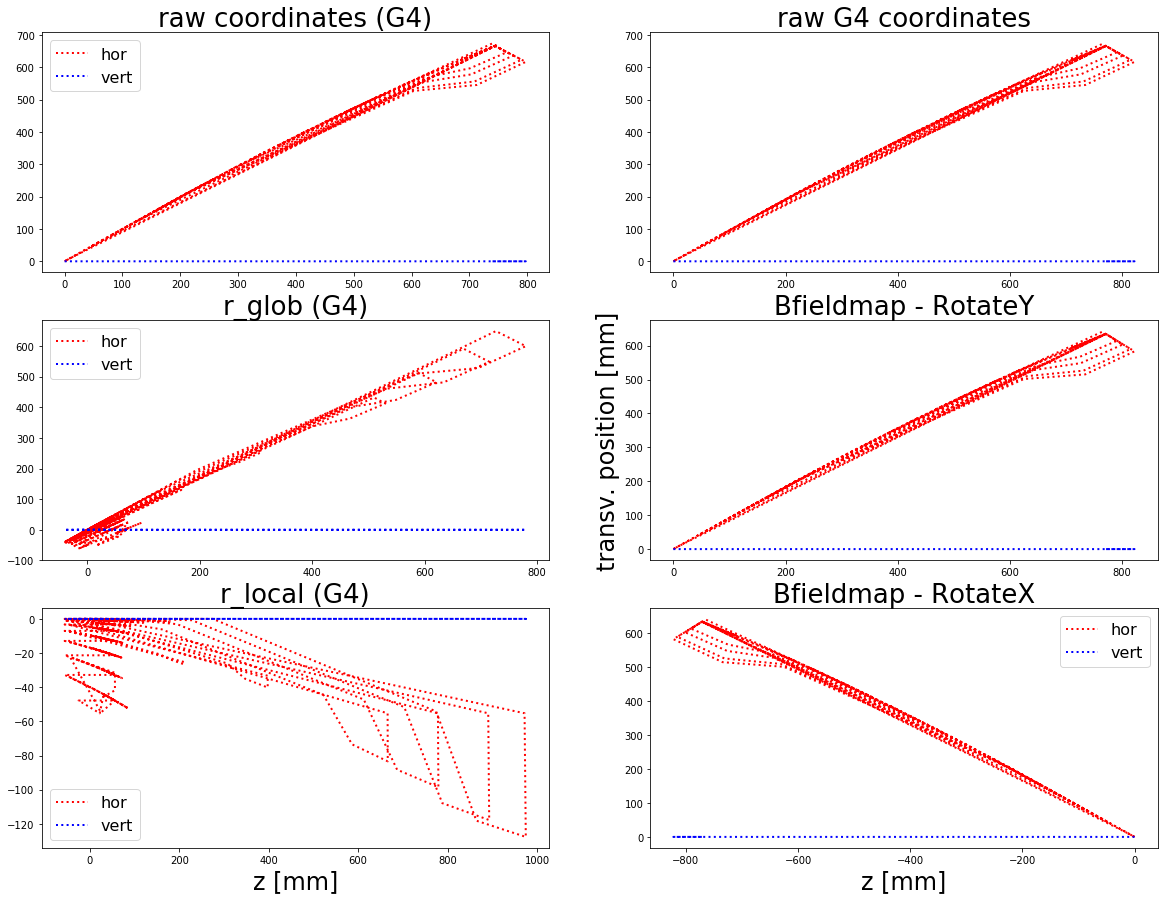

In [27]:
# plot the particle path as given by the coordinates extracted from G4QuadrupoleMagField
#
axs = sbplSetUp(6, [20,15])

# Geant4 data
# plot x and y vs z (simple particle position)
axs[0].plot(magFieldData.y2, magFieldData.y0, 'r:', label = 'hor')
axs[0].plot(magFieldData.y2, magFieldData.y1, 'b:', label = 'vert')
axs[0].legend();
axs[0].set_title('raw coordinates (G4)')

# position wrt quadrupole center
axs[2].plot(magFieldData.z_glob, magFieldData.x_glob, 'r:', label = 'hor')
axs[2].plot(magFieldData.z_glob, magFieldData.y_glob, 'b:', label = 'vert')
axs[2].legend()
axs[2].set_title('r_glob (G4)')

# position after rotation in quad frame
axs[4].plot(magFieldData.z_loc, magFieldData.x_loc, 'r:', label = 'hor')
axs[4].plot(magFieldData.z_loc, magFieldData.y_loc, 'b:', label = 'vert')
axs[4].legend()
axs[4].set_title('r_local (G4)')
axs[4].set_xlabel('z [mm]');

# # Bfieldmap
# x and y vs. z (simple particle position)
axs[1].plot(magFieldData.z_SAD, magFieldData.y0, 'r:', label = 'hor')
axs[1].plot(magFieldData.z_SAD, magFieldData.y1, 'b:', label = 'vert')
axs[1].set_title('raw G4 coordinates')

# after correcting for crossing angle 
axs[3].plot(magFieldData.z_SAD, magFieldData.x_SAD, 'r:', label = 'hor')
axs[3].plot(magFieldData.z_SAD, magFieldData.y_SAD, 'b:', label = 'vert')
axs[3].set_title('Bfieldmap - RotateY')

# after flipping y and z coordinate
axs[5].plot(magFieldData.z_SAD_loc, magFieldData.x_SAD_loc, 'r:', label = 'hor')
axs[5].plot(magFieldData.z_SAD_loc, magFieldData.y_SAD_loc, 'b:', label = 'vert')
axs[5].set_title('Bfieldmap - RotateX'); axs[5].legend(); #axs[5].set_ylim(2e-1,3e-1)

# # plt.savefig("/home/mlueckhof/temporary/SingleQuad_XA45_noOffs_corrected.pdf", dpi = 150)
axs[3].set_ylabel('transv. position [mm]')
# plt.legend();
axs[5].set_xlabel('z [mm]');

# plt.tight_layout();
plt.savefig(plotpath + "/G4_vsBfield_Trafo_SnglQd_on_Xoffset.pdf", dpi = 150, bbox_inches = 'tight')
# plt.figure( figsize = (10,8))
# plt.plot(magFieldData.z_SAD_displ, magFieldData.x_SAD_displ, 'r.', label = 'hor')
# plt.plot(magFieldData.z_SAD_displ, magFieldData.y_SAD_displ, 'b.', label = 'vert')
# plt.xlabel('z [mm]'); plt.ylabel('trns. pos. [mm]')
# plt.title('Bfieldmap - displaced coords');

## 1.2 Field based on Particle Position <a class="anchor" id="FldsPrtclPs"></a>
Above the spatial transformations are shown which are required to calculate the fields in a `G4Quadrupole` magnet. Since the field is derived **in the volume**, coordinate transformations have to make sure that the position is correct **w.r.t a coordinate system spanned in the volume**. The local field is determined by using these transformed positions `normalQuad*r_local.y(), normalQuad*r_local.x(), 0`. This example is specific to accelerator focusing magnets where a longitudinal contribution from quadrupoles can be neglected.

Important to note is that with the generic `G4QuadrupoleMagField`, the rotation of a volume comes into play by invoking the rotation matrix of that given volume. Only `r_local = (*fpMatrix)*r_global` and `B_global = fpMatrix->inverse()*B_local` take this into account. Hence, `B_local` would be a field as seen within the volume, where the crossing angle is not relevant since the volume itself is rotated.

The locally derived field components are then transformed back in the global frame to do the tracking. 

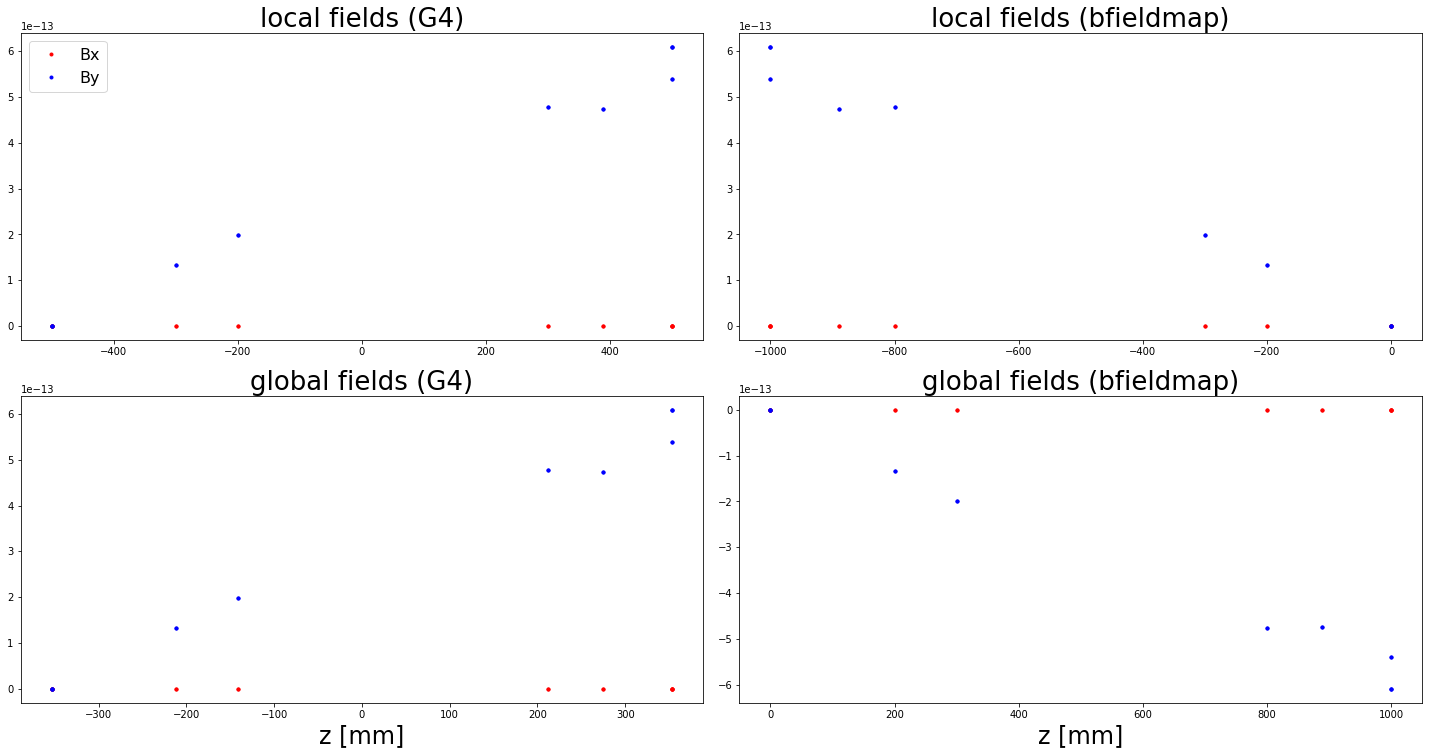

In [19]:
plt.figure( figsize = (20,15))
axs = []
for i in range(4):
    ax = plt.subplot(321+i) 
    axs.append(ax)

axs[0].plot(magFieldData.z_loc, magFieldData.Bx_loc, 'r.', label = 'Bx')
axs[0].plot(magFieldData.z_loc, magFieldData.By_loc, 'b.', label = 'By')
axs[0].legend();
axs[0].set_title('local fields (G4)')

axs[2].plot( magFieldData.z_glob, magFieldData.Bx_glob, 'r.', label = 'Bx')
axs[2].plot( magFieldData.z_glob, magFieldData.By_glob, 'b.', label = 'By')
axs[2].set_title('global fields (G4)')
axs[2].set_xlabel('z [mm]')

axs[1].plot( magFieldData.z_SAD_loc, magFieldData.B_locSAD_x, 'r.', label = 'Bx' )
axs[1].plot( magFieldData.z_SAD_loc, magFieldData.B_locSAD_y, 'b.', label = 'By' )
axs[1].set_title('local fields (bfieldmap)')

axs[3].plot( magFieldData.z_SAD, magFieldData.B_glbSAD_x, 'r.', label = 'Bx' )
axs[3].plot( magFieldData.z_SAD, magFieldData.B_glbSAD_y, 'b.', label = 'By' )
axs[3].set_xlabel('z [mm]'); axs[3].set_title('global fields (bfieldmap)')

plt.tight_layout()

## 1.3 Comparison of Field Components <a class="anchor" id="cmprsFldCmpts"></a>
Since there are two ways of calculating the field components (MDISim vs. bfieldmap) a comparison can point to possible differences. 
Should help to clarify if another transformation is required or not. Currently observing unreasonably large fields in case of quads for tracking results --> mismatch between `G4QuadrupoleMagField` and `SteppingAction`

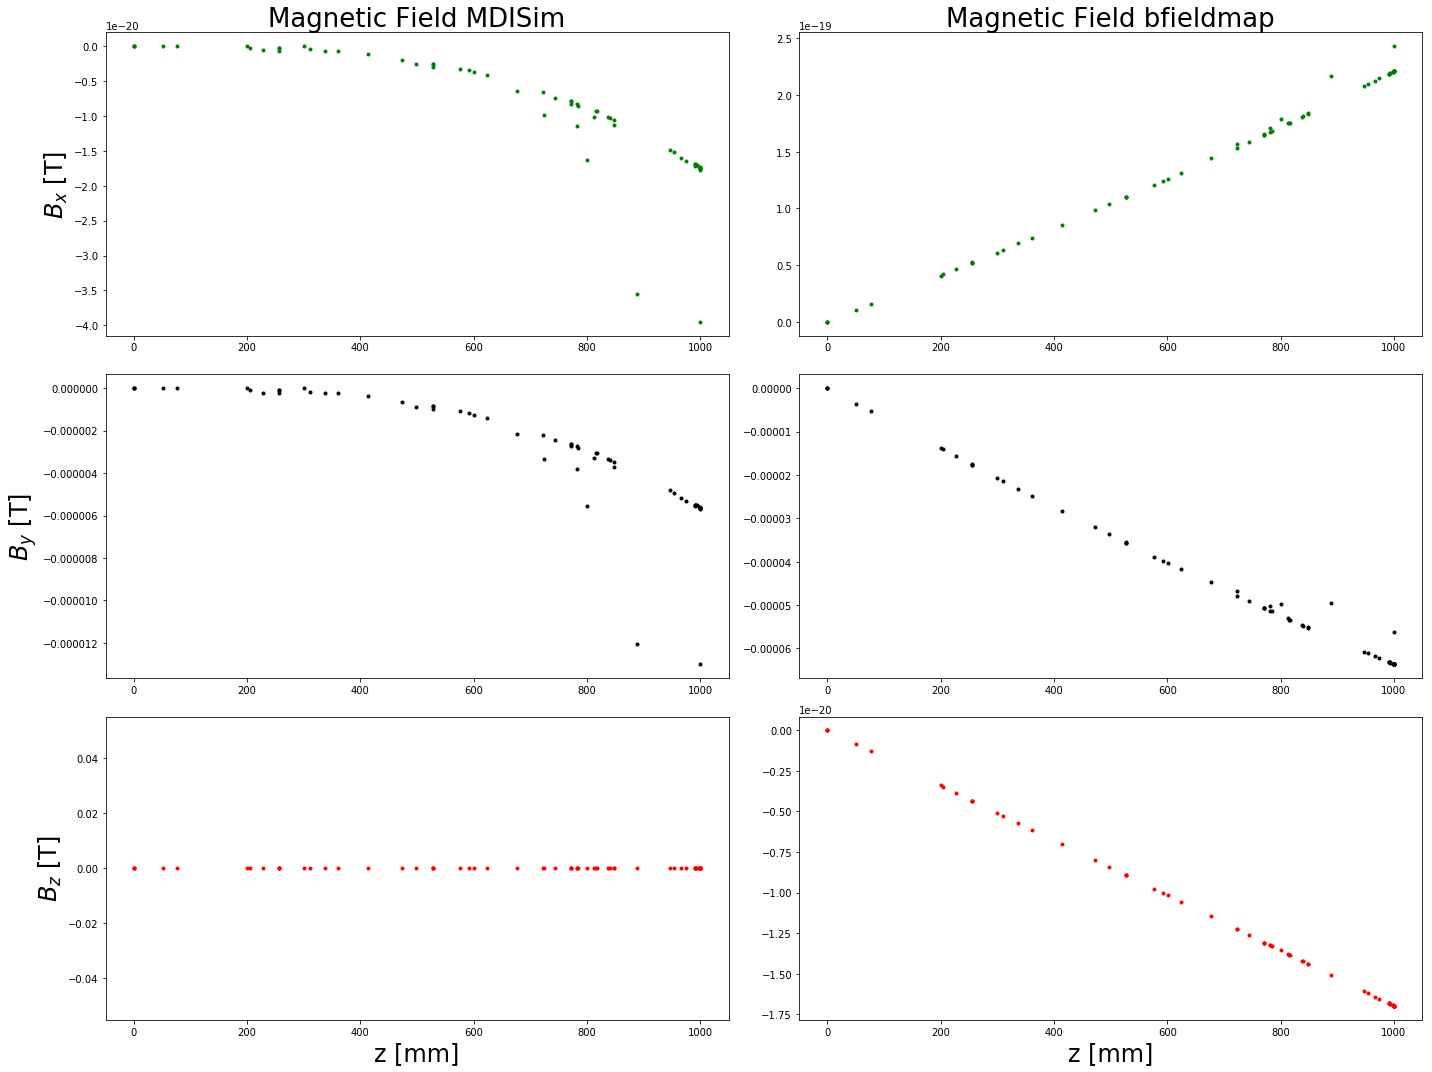

In [19]:
plt.figure( figsize = (20,15))
axs = []
for i in range(6):
    ax = plt.subplot(321+i) 
    axs.append(ax)

# plain MDISim --> G4QuadrupoleMagField
#
axs[0].set_title('Magnetic Field MDISim')
axs[0].plot(magFieldData.y2, magFieldData.Bx_glob, 'g.')
axs[0].set_ylabel('$B_x$ [T]');

axs[2].plot(magFieldData.y2, magFieldData.By_glob, 'k.')
axs[2].set_ylabel('$B_y$ [T]');

axs[4].plot(magFieldData.y2, magFieldData.Bz_glob, 'r.')
axs[4].set_ylabel('$B_z$ [T]'); axs[4].set_xlabel('z [mm]')

# data from calculation as in bfieldmap
#
axs[1].set_title('Magnetic Field bfieldmap')
axs[1].plot(magFieldData.y2, magFieldData.B_glbSAD_x, 'g.')

axs[3].plot(magFieldData.y2, magFieldData.B_glbSAD_y, 'k.')

axs[5].plot(magFieldData.y2, magFieldData.B_glbSAD_z, 'r.')
axs[5].set_xlabel('z [mm]')

plt.tight_layout()
# plt.savefig( plotpath + "Fields_MDI_vs_bfieldmap_K1sad_SK1.pdf", dpi = 150, bbox_inches = 'tight' )